In [1]:
from math import ceil
import numpy as np
import pandas as pd
from pandas.plotting import scatter_matrix

from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import train_test_split

from basis_expansions.basis_expansions import NaturalCubicSpline
from regression_tools.dftransformers import (
    ColumnSelector, Identity,
    FeatureUnion, MapFeature,
    StandardScaler)
from regression_tools.plotting_tools import (plot_univariate_smooth,
                                bootstrap_train,
                                display_coef,
                                plot_bootstrap_coefs,
                                plot_partial_depenence,
                                plot_partial_dependences,
                                predicteds_vs_actuals)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

np.random.seed(154)

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:800: MatplotlibDeprecationWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  mplDeprecation)


In [2]:
balance = pd.read_csv('balance.csv')
balance = balance.drop(balance.columns[[0]], axis=1)
balance["Balance"] = balance["Balance"] + np.random.normal(0, 750.0, size=balance.shape[0])
balance = balance[balance["Balance"] >= 0]

In [3]:
numeric_predictors = [
    "Income", "Limit", "Rating", "Cards", "Age", "Education"]

In [4]:
def simple_spline_specification(name, knots):
    select_name = "{}_select".format(name)
    spline_name = "{}_spline".format(name)
    return Pipeline([
        (select_name, ColumnSelector(name=name)),
        (spline_name, NaturalCubicSpline(knots=knots))
    ])

In [5]:
income_spec = simple_spline_specification("Income", [25, 50, 75, 100, 125])
limit_spec = simple_spline_specification("Limit", [3000, 4000, 5000, 6000, 7000, 8000])
rating_spec = simple_spline_specification("Rating", [200, 300, 400, 500, 600])
age_spec = simple_spline_specification("Age", [30, 40, 50, 60, 70])
education_spec = simple_spline_specification("Education", [8, 10, 12, 14, 16])

In [6]:
def simple_indicator_specification(var_name, levels):
    select_name = "{}_select".format(var_name)
    map_features = []
    for level in levels:
        indicator_name = "{}_{}_indicator".format(var_name, level)
        map_features.append(
            (indicator_name, MapFeature(lambda var: var == level, indicator_name))
        )
    return Pipeline([
        (select_name, ColumnSelector(name=var_name)),
        ("indicator_features", FeatureUnion(map_features))
    ])

In [7]:
cards_spec = simple_indicator_specification("Cards", [0, 1, 2, 3])
is_female = simple_indicator_specification("Gender", "Female")
student_spec = simple_indicator_specification("Student", "Yes")
married_spec = simple_indicator_specification("Married", "Yes")

In [8]:
continuous_features_scaled = Pipeline([
    ('continuous_features', FeatureUnion([
        ('income_fit', income_spec),
        ('limit_fit', limit_spec),
        ('rating_fit', rating_spec),
        ('age_fit', age_spec),
        ('education_fit', education_spec)])),
    ('standardizer', StandardScaler())
])
    
    
indicator_features = FeatureUnion([
    ('cards_fit', cards_spec),
    ('education_fit', education_spec),
    ('student_fit', student_spec),
    ('married_fit', married_spec)
])

balance_pipeline = FeatureUnion([
    ('continuous_features', continuous_features_scaled),
    ('indicator_features', indicator_features)
])

### Train and Test

In [9]:
train_raw, test_raw = train_test_split(balance, test_size=0.33)

In [10]:
balance_pipeline.fit(train_raw)
balance_train = balance_pipeline.transform(train_raw)
balance_test = balance_pipeline.transform(test_raw)

In [11]:
def standardize_y(y_train, y_test):
    y_mean, y_std = np.mean(y_train), np.std(y_test)
    y_train_std = (y_train - y_mean) / y_std
    y_test_std = (y_test - y_mean) / y_std
    return y_train_std, y_test_std

In [12]:
y_train, y_test = standardize_y(train_raw["Balance"], test_raw["Balance"])

### Ridge Regression

In [13]:
from sklearn.linear_model import Ridge

In [14]:
ridge_regularization_strengths = np.logspace(np.log10(0.0001), np.log10(1000))

ridge_regressions = []
for alpha in ridge_regularization_strengths:
    ridge = Ridge(alpha=alpha)
    ridge.fit(balance_train, y_train)
    ridge_regressions.append(ridge)

In [15]:
def plot_solution_paths(ax, regressions):
    alphas = [np.log10(ridge.alpha) for ridge in regressions]
    coeffs = np.concatenate([ridge.coef_.reshape(1, -1) 
                             for ridge in regressions])
    for idx in range(coeffs.shape[1]):
        ax.plot(alphas, coeffs[:, idx])
    ax.set_xlabel(r"$\log_{10}(\alpha)$")
    ax.set_ylabel("Estiamted Coefficient")
    ax.set_title("Coefficient Paths")

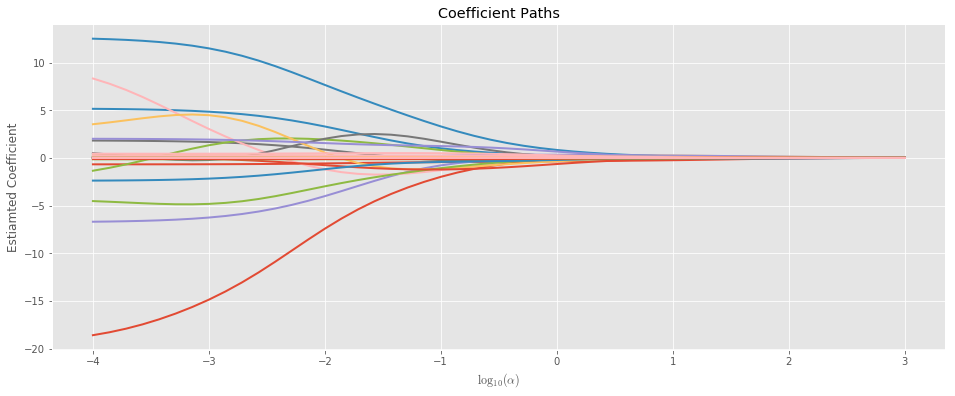

In [16]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_solution_paths(ax, ridge_regressions)

In [17]:
def rss(model, X, y):
    preds = model.predict(X)
    n = X.shape[0]
    return np.sum((y - preds)**2) / n

def train_and_test_error(regressions, X_train, y_train, X_test, y_test):
    alphas = [ridge.alpha for ridge in regressions]
    train_scores = [rss(reg, X_train, y_train) for reg in regressions]
    test_scores = [rss(reg, X_test, y_test) for reg in regressions]
    return pd.DataFrame({
        'train_scores': train_scores,
        'test_scores': test_scores,
    }, index=alphas)

def get_optimal_alpha(train_and_test_errors):
    test_errors = train_and_test_errors["test_scores"]
    optimal_idx = np.argmin(test_errors.values)
    return train_and_test_errors.index[optimal_idx]

def plot_train_and_test_error(ax, train_and_test_errors, alpha=1.0, legend=True):
    alphas = train_and_test_errors.index
    optimal_alpha = get_optimal_alpha(train_and_test_errors)
    ax.plot(np.log10(alphas), train_and_test_errors.train_scores, label="Train MSE",
            color="blue", alpha=alpha)
    ax.plot(np.log10(alphas), train_and_test_errors.test_scores, label="Test MSE",
            color="red", alpha=alpha)
    ax.axvline(x=np.log10(optimal_alpha), color="grey", alpha=alpha)
    ax.set_xlabel(r"$\log_{10}(\alpha)$")
    ax.set_ylabel("Mean Squared Error")
    ax.set_title("Mean Squared Error vs. Regularization Strength")
    if legend:
        ax.legend()

In [18]:
train_and_test_errors = train_and_test_error(ridge_regressions, balance_train, y_train, balance_test, y_test)

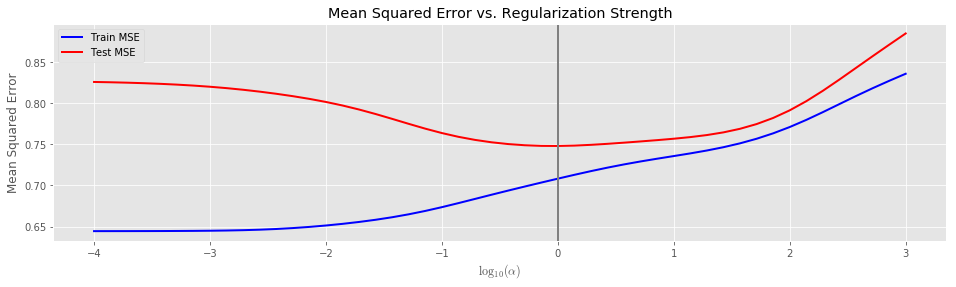

In [19]:
fig, ax = plt.subplots(figsize=(16, 4))
plot_train_and_test_error(ax, train_and_test_errors)

## Lasso

In [20]:
from sklearn.linear_model import Lasso

In [21]:
lasso_regularization_strengths = np.logspace(np.log10(0.00001), np.log10(1))

lasso_regressions = []
for alpha in lasso_regularization_strengths:
    lasso = Lasso(alpha=alpha)
    lasso.fit(balance_train, y_train)
    lasso_regressions.append(lasso)

/Users/matthewdrury/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


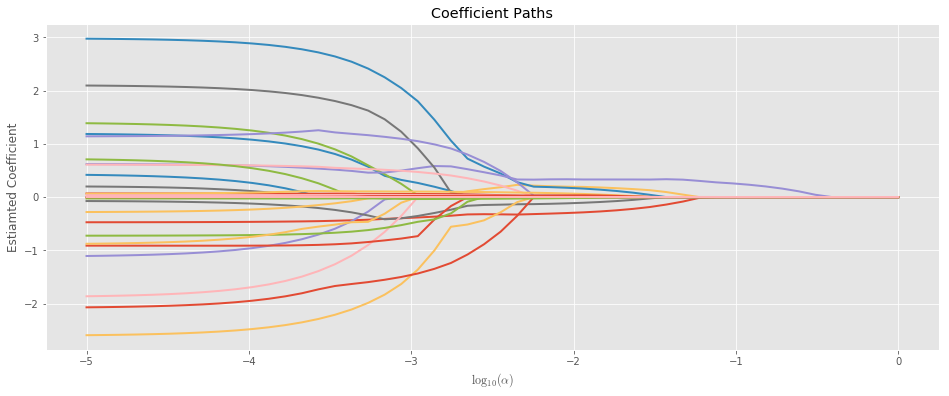

In [22]:
fig, ax = plt.subplots(figsize=(16, 6))
plot_solution_paths(ax, lasso_regressions)

In [23]:
train_and_test_errors = train_and_test_error(lasso_regressions, balance_train, y_train, balance_test, y_test)

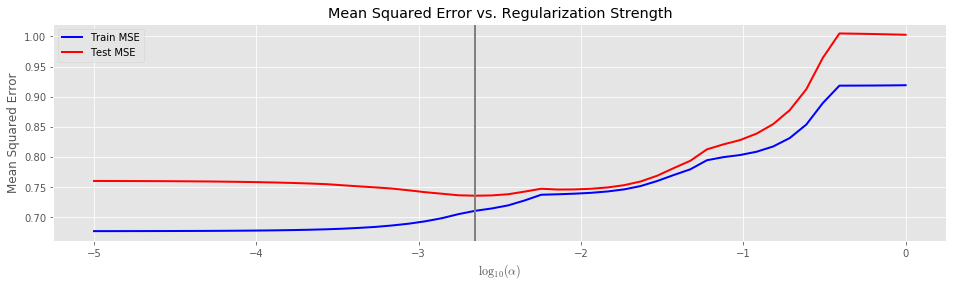

In [24]:
fig, ax = plt.subplots(figsize=(16, 4))
plot_train_and_test_error(ax, train_and_test_errors)

## Using Ridge and Lasso with Cross Validation

In [25]:
from sklearn.model_selection import KFold

In [26]:
n_folds=10

cv_models = []
errors = []
splitter = KFold(n_splits=n_folds)
for train_idxs, test_idxs in splitter.split(balance):
    # Split the raw data into train and test
    train_raw, test_raw = balance.iloc[train_idxs], balance.iloc[test_idxs]
    
    # Fit and transform the raw data.
    # All training of the transformers must only touch the training data!
    balance_pipeline.fit(train_raw)
    balance_train = balance_pipeline.transform(train_raw)
    balance_test = balance_pipeline.transform(test_raw)
    y_train, y_test = standardize_y(train_raw["Balance"], test_raw["Balance"])
    
    # Fit all the models at different regularization strengths
    ridge_regressions = []
    for alpha in ridge_regularization_strengths:
        ridge = Ridge(alpha=alpha)
        ridge.fit(balance_train, y_train)
        ridge_regressions.append(ridge)
    cv_models.append(ridge_regressions)
    
    # Calculate the error curves for each CV fold, for each regularization strength
    train_and_test_errors = train_and_test_error(
        ridge_regressions, balance_train, y_train, balance_test, y_test)
    errors.append(train_and_test_errors)
    
    # Calculate the mean errors across all CV folds, for each regularization strength
    train_errors = np.empty(shape=(n_folds, len(ridge_regularization_strengths)))
    for idx, tte in enumerate(errors):
        te = tte['train_scores']
        train_errors[idx, :] = te
    mean_train_errors = np.mean(train_errors, axis=0)
    
    test_errors = np.empty(shape=(n_folds, len(ridge_regularization_strengths)))
    for idx, tte in enumerate(errors):
        te = tte['test_scores']
        test_errors[idx, :] = te
    mean_test_errors = np.mean(test_errors, axis=0)
    
    mean_errors = pd.DataFrame({
        'train_scores': mean_train_errors,
        'test_scores': mean_test_errors,
    }, index=ridge_regularization_strengths)

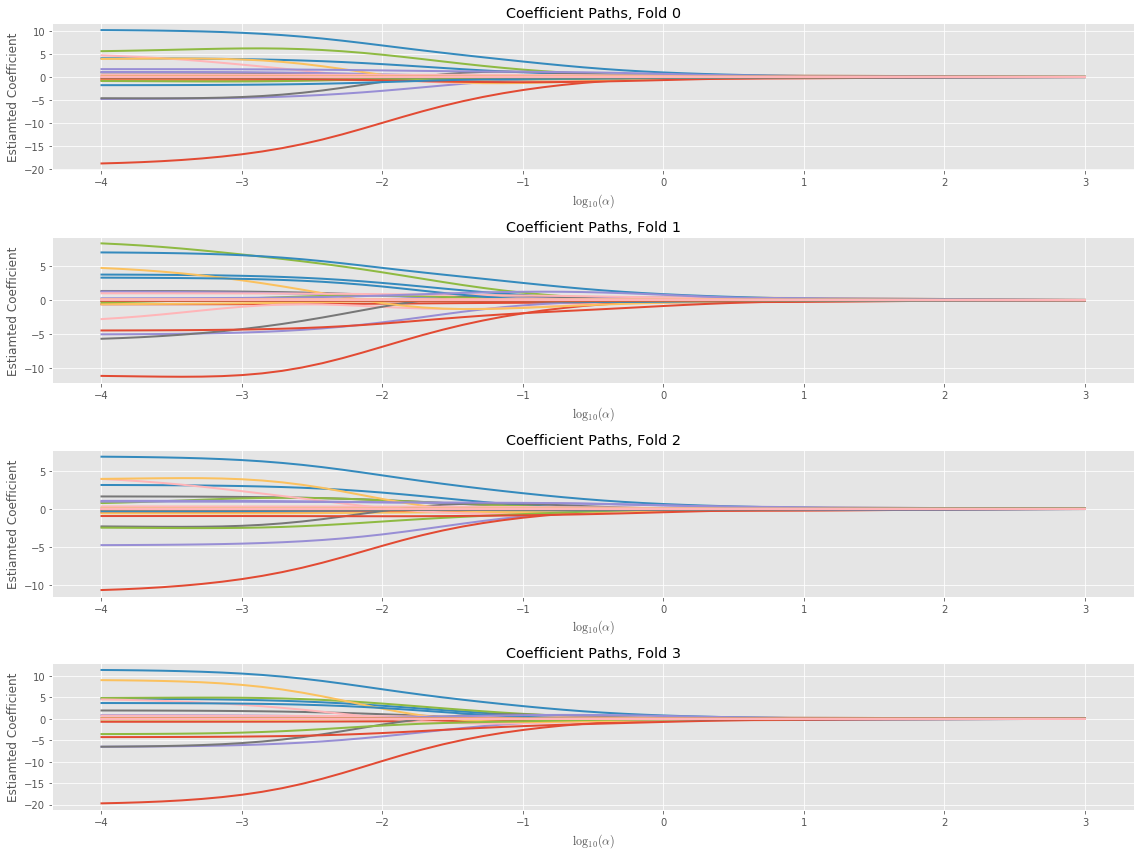

In [27]:
fig, axs = plt.subplots(4, 1, figsize=(16, 12))

for idx, ax in enumerate(axs):
    plot_solution_paths(ax, cv_models[idx])
    ax.set_title("Coefficient Paths, Fold {}".format(idx))
fig.tight_layout()

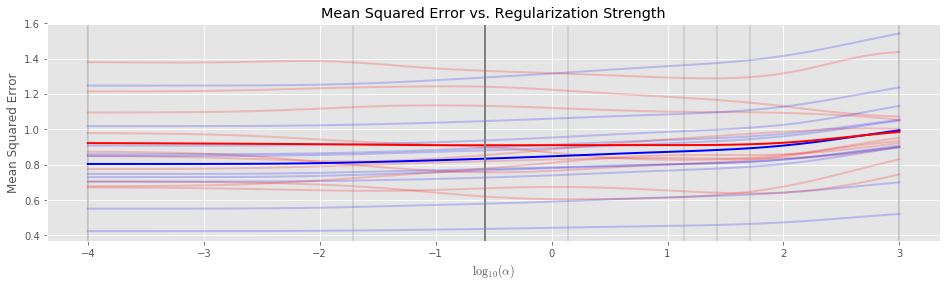

In [28]:
fig, ax = plt.subplots(figsize=(16, 4))

for ttes in errors:
    plot_train_and_test_error(ax, ttes, alpha=0.2, legend=False)
plot_train_and_test_error(ax, mean_errors, legend=False)